In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVR
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn import preprocessing
from datetime import datetime
from scipy import stats
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

sns.set()
sns.set(color_codes=True)
#sns.set_color_codes()

pd.options.display.max_rows = 15
pd.options.display.float_format = '{:,.3f}'.format

In [33]:
# 1- read data file
# 1- read processed file
file_dir = '../data/processed-data/'

non_normalized_data_file = 'missing_outliers_processed_dataset.csv'
normalized_data_file = 'normalized_dataset.csv'
factored_data_file = 'factored_dataset.csv'

data = pd.read_csv(file_dir + normalized_data_file)

In [34]:
data.head(5)

,ltcy,svc_cpu_use,svc_cpu_thr,svc_net_use,svc_disk_use,system_cpu_use,system_cpu_sat,system_net_use,svc_req_size,svc_resp_size,svc_pods,svc_req_rate
0,0.332,0.557,0.332,0.325,0.037,16.982,1.591,3.206,0.002,0.012,7.000,0.980
1,0.400,0.616,0.300,0.351,0.047,20.583,1.608,3.552,0.003,0.019,7.000,1.620
2,0.469,0.608,0.316,0.362,0.039,19.448,1.390,3.586,0.003,0.024,7.000,2.180
3,0.490,0.624,0.300,0.362,0.108,17.319,1.730,3.512,0.003,0.022,6.000,2.130
4,0.500,0.608,0.316,0.374,0.133,16.650,1.917,3.449,0.003,0.023,3.000,2.220


## Linear Regression Model

In [35]:
targets = data['ltcy']
inputs = data.drop(['ltcy'], axis=1)

#inputs_scaled = scaler.fit_transform(inputs)
#x_train, x_test, y_train, y_test = train_test_split(inputs_scaled, targets, test_size=0.2, random_state=365)

x_train, x_test, y_train, y_test = \
    train_test_split(inputs, targets, test_size=0.2, random_state=365)

# for better convergence and result scale target to values between 0 - 1
maxltcy = targets.max()
y_train = y_train / maxltcy
y_test = y_test / maxltcy



In [36]:
# standardize the features
scaler = StandardScaler()

# using SelectFromModel metatransformer to select features
clf = LassoCV()
sfm = SelectFromModel(clf, threshold=0.01)

# SVM
svr = LinearSVR(C=0.1, verbose=1)

pline = Pipeline([
    ('scaler', scaler),
    ('feature_selection', sfm),
    ('regression', svr)
])

kfold = KFold(n_splits=10)
results = cross_val_score(pline, x_train , y_train, cv=kfold)

print ("Done..!")

y_hat = pline.fit(x_train, y_train)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Done..!
[LibLinear]

In [37]:
y_hat = pline.predict(x_train)

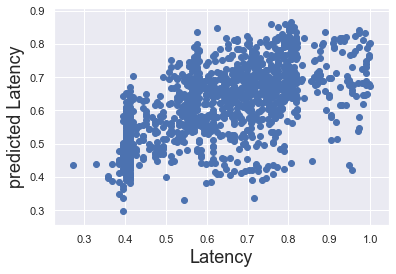

In [38]:
plt.scatter(y_train, y_hat)
plt.xlabel('Latency', size=18)
plt.ylabel("predicted Latency", size=18)
#plt.xlim(-2,3)
#plt.ylim(-3,1)
plt.show()

Text(0.5, 1.0, 'Residual PDF')

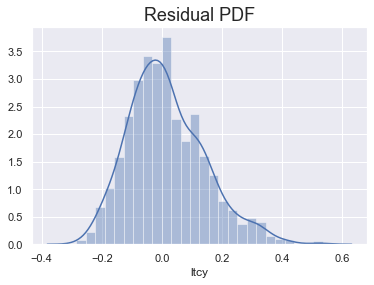

In [39]:
sns.distplot(y_train - y_hat)
plt.title('Residual PDF', size=18)

In [40]:
# R-Squared
pline.score(x_train, y_train)

0.3426049169960508

In [41]:
pline.named_steps.regression.intercept_

array([0.62231059])

In [42]:
pline.named_steps.regression.coef_

array([-0.00767418,  0.02026131, -0.0623563 , -0.01751681,  0.16911612])

In [43]:
selector = pline.named_steps.feature_selection
selected_features = selector.transform(inputs)
number_of_features = selected_features.shape[1]

features = []
for i in range(number_of_features):
    features.append('Feature_' + str(i))

reg_summary = pd.DataFrame(features, columns=['features'])
reg_summary['weights'] = pline.named_steps.regression.coef_
reg_summary

,features,weights
0,Feature_0,-0.008
1,Feature_1,0.020
2,Feature_2,-0.062
3,Feature_3,-0.018
4,Feature_4,0.169


In [44]:
# validation mean_absolute_percentage_error
train_error =  np.abs(y_train - y_hat)
mean_error = np.mean(train_error)
min_error = np.min(train_error)
max_error = np.max(train_error)
std_error = np.std(train_error)

print("Model Result (mean and std of error): %.2f (%.2f) MSE" % (mean_error, std_error))

Model Result (mean and std of error): 0.10 (0.08) MSE


### Testing

In [45]:
y_hat_test = pline.predict(x_test)

<function matplotlib.pyplot.show(*args, **kw)>

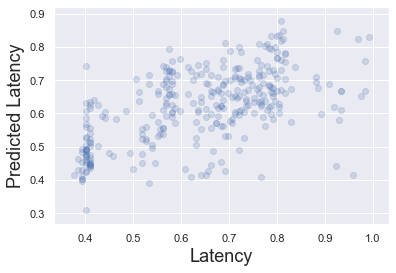

In [46]:
plt.scatter(y_test, y_hat_test, alpha=0.2)
plt.xlabel('Latency', size=18)
plt.ylabel('Predicted Latency', size=18)
plt.show

In [47]:
perf = pd.DataFrame(np.exp(y_hat_test), columns=['prediction'])
y_test = y_test.reset_index(drop=True)
perf['target'] = np.exp(y_test)
perf.head()

,prediction,target
0,1.971,1.767
1,1.925,1.778
2,1.687,1.682
3,2.126,2.266
4,2.146,1.819


In [48]:
# testing mean_absolute_percentage_error
perf['residual'] = perf['prediction'] - perf['target']
perf['difference%'] = np.absolute(perf['residual'] * 100 / perf['target'])
perf

,prediction,target,residual,difference%
0,1.971,1.767,0.204,11.524
1,1.925,1.778,0.147,8.291
2,1.687,1.682,0.005,0.300
3,2.126,2.266,-0.140,6.170
4,2.146,1.819,0.327,17.947
...,...,...,...,...
312,2.294,2.700,-0.406,15.022
313,2.142,2.134,0.008,0.391
314,2.185,2.266,-0.081,3.575
315,1.873,2.238,-0.365,16.296


In [49]:
perf.describe()

,prediction,target,residual,difference%
count,317.000,317.000,317.000,317.000
mean,1.873,1.921,-0.048,9.657
std,0.205,0.292,0.245,7.451
min,1.364,1.457,-1.094,0.018
25%,1.717,1.704,-0.207,3.540
50%,1.881,1.940,-0.012,8.292
75%,2.018,2.143,0.117,13.557
max,2.404,2.700,0.605,41.963


In [50]:
pd.options.display.max_rows = 999
pd.set_option('display.float_format', lambda x: '%.2f' % x)
perf.sort_values(by = ['difference%'])

,prediction,target,residual,difference%
156,2.02,2.02,-0.00,0.02
87,1.99,1.99,0.00,0.11
249,2.04,2.04,0.00,0.11
202,1.99,1.99,-0.00,0.13
7,1.49,1.48,0.00,0.14
81,1.95,1.95,-0.00,0.25
2,1.69,1.68,0.01,0.30
77,1.74,1.75,-0.01,0.30
94,1.96,1.97,-0.01,0.31
313,2.14,2.13,0.01,0.39
